# Italian model

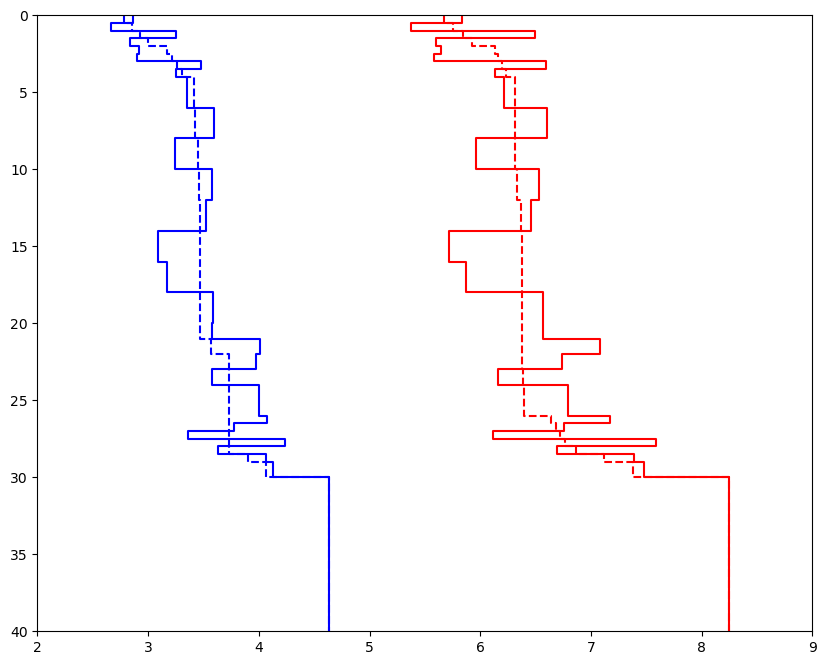

In [23]:
# Import necessary libraries
import numpy as np  # For numerical operations and arrays
import pyfk  # For synthetic seismogram and modeling tools
import obspy  # For seismology data structures and tools
from pyfk import SourceModel, SeisModel, Config  # Import specific classes from pyfk
from pyfk import calculate_gf  # Function to calculate Green's functions
from pyfk import calculate_sync  # Function to calculate synthetic seismograms
from pyfk import generate_source_time_function  # Function to generate source time functions
import matplotlib.pyplot as plt  # For plotting

# --- Define the model parameters as strings (layer depths, P-wave velocity, Kappa) ---
# These are the depths (in km) of the top of each layer in the model
Toplayer = '0.00  0.50  1.00  1.50  2.00  2.50  3.00  3.50  4.00  6.00  8.00 10.00 12.00 14.00 16.00 18.00 20.00 21.00 22.00 23.00 24.00 26.00 26.50 27.00 27.50 28.00 28.50 29.00 30.00'
# P-wave velocity (Vp) in km/s for each layer
Vp       = '5.670 5.756 5.843 5.929 6.130 6.164 6.197 6.231 6.310 6.310 6.310 6.332 6.370 6.372 6.374 6.376 6.380 6.380 6.380 6.384 6.390 6.640 6.681 6.723 6.764 6.860 7.121 7.381 8.250'
# Kappa is the ratio Vp/Vs (used to calculate S-wave velocity)
Kappa    = '2.040 2.018 1.997 1.977 1.934 1.917 1.901 1.885 1.850 1.842 1.829 1.832 1.836 1.836 1.837 1.837 1.839 1.788 1.710 1.711 1.713 1.780 1.791 1.802 1.813 1.839 1.827 1.816 1.78'

# --- Convert the strings to numpy arrays of floats ---
Toplayer = np.array(Toplayer.split()).astype(float)  # Depths of each layer (km)
Vp = np.array(Vp.split()).astype(float)  # P-wave velocity (km/s)
Kappa = np.array(Kappa.split()).astype(float)  # Ratio Vp/Vs

# --- Calculate S-wave velocity (Vs) from Vp and Kappa ---
Vs = Vp / Kappa  # S-wave velocity (Vs = Vp / Kappa)

# --- Build the model data array ---
# Each row: [thickness, Vs, Vp, density, Qp, Qs]
# thickness: thickness of the layer (km)
# Vs: S-wave velocity (km/s)
# Vp: P-wave velocity (km/s)
# density: calculated as 0.77 + 0.32 * Vp (empirical relation)
# Qp, Qs: quality factors (set to 100 for both)
model_data = []
# First layer: thickness is the difference between first two depths, plus a small offset (0.01 km)
model_data.append([Toplayer[1] - Toplayer[0] + 0.01, Vs[0], Vp[0], 0.77 + 0.32 * Vp[0], 100, 100])
# Middle layers: loop through each layer and calculate thickness and properties
for i in range(1, len(Vp) - 1):
    model_data.append([Toplayer[i + 1] - Toplayer[i], Vs[i], Vp[i], 0.77 + 0.32 * Vp[i], 100, 100])
# Last layer: make it very thick (200 km) to represent the mantle
model_data.append([200, Vs[-1], Vp[-1], 0.77 + 0.32 * Vp[-1], 100, 100])

model_data = np.array(model_data)  # Convert to numpy array for easier use

# --- Create a SeisModel object for use with pyfk ---
model = SeisModel(model=model_data)

# --- Prepare sources at different depths ---
sources = []
depths = np.arange(1, 41, 1)  # Source depths from 1 to 40 km (step 1 km)

for i in range(len(depths)):
    # Create a double-couple source (typical earthquake) at each depth
    source = SourceModel(sdep=depths[i], srcType="dc")
    # Create a configuration for each source (not used further in this notebook)
    config = Config(
        model=model,
        source=source,
        npt=2048,  # Number of points in synthetic seismogram
        dt=0.02,   # Time step (s)
        receiver_distance=np.arange(1, 151, 1))  # Receiver distances (km)
    sources.append(source)

# --- Plot the velocity model ---
plt.figure(figsize=(10, 8))  # Set figure size

# Calculate slowness (thickness/velocity) for P and S waves
slow_p = model_data[:, 0] / model_data[:, 2]  # P-wave slowness
slow_s = model_data[:, 0] / model_data[:, 1]  # S-wave slowness

# Add random perturbations to slowness for scattering model
k = np.random.randn(len(slow_p))  # Random numbers for each layer
k[-1] = 0  # No perturbation for last layer
slow_p += k * 0.01 * model_data[:, 0]  # Add small random perturbation to P-wave slowness
slow_s += k * 0.02 * model_data[:, 0]  # Add small random perturbation to S-wave slowness

# Recalculate velocities from perturbed slowness
Vp_n = model_data[:, 0] / slow_p  # New P-wave velocities
Vs_n = model_data[:, 0] / slow_s  # New S-wave velocities

# Copy model data and update velocities for scattering model
model_data_n = model_data.copy()
model_data_n[:, 1] = Vs_n  # Update S-wave velocity
model_data_n[:, 2] = Vp_n  # Update P-wave velocity

# --- Prepare data for plotting ---
vpx = []  # P-wave velocities (scattering)
vsx = []  # S-wave velocities (scattering)
dep = []  # Depths
vpx_n = []  # P-wave velocities (original)
vsx_n = []  # S-wave velocities (original)
for i in range(0, len(Vp_n) - 1):
    vpx.append(Vp_n[i])
    vpx.append(Vp_n[i])
    vsx.append(Vs_n[i])
    vsx.append(Vs_n[i])
    vpx_n.append(Vp[i])
    vpx_n.append(Vp[i])
    vsx_n.append(Vs[i])
    vsx_n.append(Vs[i])
    dep.append(Toplayer[i])
    dep.append(Toplayer[i + 1])
vpx.append(Vp_n[-1])
vpx.append(Vp_n[-1])
vsx.append(Vs_n[-1])
vsx.append(Vs_n[-1])
vpx_n.append(Vp[-1])
vpx_n.append(Vp[-1])
vsx_n.append(Vs[-1])
vsx_n.append(Vs[-1])
dep.append(Toplayer[-1])
dep.append(100)  # Extend to 100 km for plot

# Plot scattering model (solid lines) and original (dashed lines)
plt.plot(vpx, dep, '-r', vsx, dep, '-b')
plt.plot(vpx_n, dep, '--r', vsx_n, dep, '--b')
plt.xlim([2, 9])  # Set x-axis limits (velocity)
plt.ylim([0, 40])  # Set y-axis limits (depth)
plt.gca().invert_yaxis()  # Depth increases downward

# Save the models as .npy files for later use
np.save('Italian_model.npy', model_data)  # Save original model
np.save('Italian_model_scattering4.npy', model_data_n)  # Save scattering model

## Create Taup Model File
This section creates model files for use with the TauP toolkit (for travel time calculation). TauP needs a specific text format describing the velocity structure.

In [13]:
fw1 = open('Italian_model.nd', 'w')  # File for original model
fw2 = open('Italian_model_scattering.nd', 'w')  # File for scattering model

append_lines = open('model_let.nd', 'r').readlines()  # Read extra lines to append (e.g., mantle)

# Write the first layer for both models
fw1.write('%6s' % str(Toplayer[0]) + '%6s' % '%.3f' % Vp[0] + '%6s' % '%.3f' % Vs[0] + '    3.0    1200    600\n')
fw2.write('%6s' % str(Toplayer[0]) + '%6s' % '%.3f' % Vp_n[0] + '%6s' % '%.3f' % Vs_n[0] + '    3.0    1200    600\n')
for i in range(1, len(Vp) - 1):
    # Write two lines for each interface (for TauP format)
    fw1.write('%6s' % str(Toplayer[i] + 0.01) + '%6s' % '%.3f' % Vp[i - 1] + '%6s' % '%.3f' % Vs[i - 1] + '    3.0    1200    600\n')
    fw1.write('%6s' % str(Toplayer[i] + 0.01) + '%6s' % '%.3f' % Vp[i] + '%6s' % '%.3f' % Vs[i] + '    3.0    1200    600\n')
    fw2.write('%6s' % str(Toplayer[i] + 0.01) + '%6s' % '%.3f' % Vp_n[i - 1] + '%6s' % '%.3f' % Vs_n[i - 1] + '    3.0    1200    600\n')
    fw2.write('%6s' % str(Toplayer[i] + 0.01) + '%6s' % '%.3f' % Vp_n[i] + '%6s' % '%.3f' % Vs_n[i] + '    3.0    1200    600\n')

# Write the last layer and mantle
fw1.write('%6s' % str(Toplayer[-1] + 0.01) + '%6s' % '%.3f' % Vp[-2] + '%6s' % '%.3f' % Vs[-2] + '    3.0    1200    600\n')
fw1.write('# mantle\n')
fw1.write('%6s' % str(Toplayer[-1] + 0.01) + '%6s' % '%.3f' % Vp[-1] + '%6s' % '%.3f' % Vs[-1] + '    3.0    1200    600\n')
fw1.write('%6s' % str(150 + 0.01) + '%6s' % '%.3f' % Vp[-1] + '%6s' % '%.3f' % Vs[-1] + '    3.0    1200    600\n')
fw2.write('%6s' % str(Toplayer[-1] + 0.01) + '%6s' % '%.3f' % Vp_n[-2] + '%6s' % '%.3f' % Vs_n[-2] + '    3.0    1200    600\n')
fw2.write('# mantle\n')
fw2.write('%6s' % str(Toplayer[-1] + 0.01) + '%6s' % '%.3f' % Vp_n[-1] + '%6s' % '%.3f' % Vs_n[-1] + '    3.0    1200    600\n')
fw2.write('%6s' % str(150 + 0.01) + '%6s' % '%.3f' % Vp_n[-1] + '%6s' % '%.3f' % Vs_n[-1] + '    3.0    1200    600\n')

# Append extra lines (e.g., for deep mantle or core)
for line in append_lines:
    fw1.write(line)
    fw2.write(line)

fw2.close()
fw1.close()

# --- Build TauP models using ObsPy ---
from obspy.taup import taup_create
# This will create .npz files for use with TauPyModel
taup_create.build_taup_model('Italian_model.nd', '.')
taup_create.build_taup_model('Italian_model_scattering.nd', '.')

Building obspy.taup model for 'Italian_model.nd' ...
filename = Italian_model.nd
Done reading velocity model.
Radius of model . is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  597 P layers,762 S layers
Done calculating Tau branches.
Done Saving ./Italian_model.npz
Method run is done, but not necessarily successful.
Building obspy.taup model for 'Italian_model_scattering.nd' ...
filename = Italian_model_scattering.nd
Done reading velocity model.
Radius of model . is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.

## Test Model travel time
This section tests the travel times calculated from the models using TauPyModel. We will compare the travel times for P and S waves at different distances.

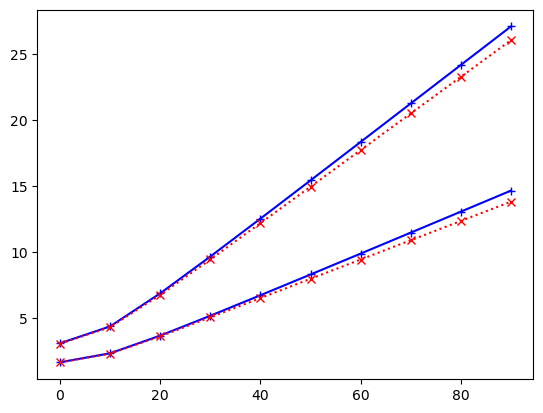

In [15]:
from obspy.taup import TauPyModel  # Import TauPyModel for travel time calculation

# Load the two models we created above
model1 = TauPyModel(model='Italian_model.npz')  # Load original model
model2 = TauPyModel(model='Italian_model_scattering.npz')  # Load scattering model

evdp = 10  # Event/source depth (km)
r = np.arange(10) * 10  # Array of distances (0, 10, ..., 90 km)

t1p = []  # List to store P-wave travel times for model1
t1s = []  # List to store S-wave travel times for model1
t2p = []  # List to store P-wave travel times for model2
t2s = []  # List to store S-wave travel times for model2

# For each distance in r, calculate the travel times for P and S waves for both models
for i in range(len(r)):
    # Calculate P-wave arrival time for model1 (original)
    arrival_p1 = model1.get_travel_times(
        source_depth_in_km=evdp,
        distance_in_degree=r[i]/110,  # Convert km to degrees (approximate)
        phase_list=['P', 'p']         # Look for P phases
    )[0].time
    # Calculate S-wave arrival time for model1 (original)
    arrival_s1 = model1.get_travel_times(
        source_depth_in_km=evdp,
        distance_in_degree=r[i]/110,
        phase_list=['S', 's']         # Look for S phases
    )[0].time
    # Calculate P-wave arrival time for model2 (scattering)
    arrival_p2 = model2.get_travel_times(
        source_depth_in_km=evdp,
        distance_in_degree=r[i]/110,
        phase_list=['P', 'p']
    )[0].time
    # Calculate S-wave arrival time for model2 (scattering)
    arrival_s2 = model2.get_travel_times(
        source_depth_in_km=evdp,
        distance_in_degree=r[i]/110,
        phase_list=['S', 's']
    )[0].time
    # Store the results in the lists
    t1p.append(arrival_p1)
    t1s.append(arrival_s1)
    t2p.append(arrival_p2)
    t2s.append(arrival_s2)

# Plot the travel times for P and S waves for both models
plt.plot(r, t1p, '-b+', label='P (original)')
plt.plot(r, t2p, ':rx', label='P (scattering)')
plt.plot(r, t1s, '-g+', label='S (original)')
plt.plot(r, t2s, ':mx', label='S (scattering)')
plt.xlabel('Distance (km)')
plt.ylabel('Travel Time (s)')
plt.title('Travel Times for P and S Waves')
plt.legend()
plt.show()



## Calculate Green Function
This section calculates the Green's functions for each source depth. Green's functions describe the response of the Earth to a point source and are used to generate synthetic seismograms.

In [37]:
gfs = []  # List to store Green's functions for each depth
for i in range(len(depths)):
    print('calculating green function for source depth: ' + str(depths[i]).zfill(2) + 'km')
    source = SourceModel(sdep=depths[i], srcType="dc")  # Double-couple source at this depth
    config = Config(
        model=model,
        source=source,
        npt=2048,  # Number of time points
        dt=0.02,   # Time step (seconds)
        receiver_distance=np.arange(1, 151, 1)  # Receiver distances from 1 to 150 km
    )
    gf = calculate_gf(config)  # Calculate Green's function for this configuration
    gfs.append(gf)  # Store the result
    sources.append(source)  # Store the source (optional)

calculating green function for source depth: 01km
calculating green function for source depth: 02km
calculating green function for source depth: 03km
calculating green function for source depth: 04km
calculating green function for source depth: 05km
calculating green function for source depth: 06km
calculating green function for source depth: 07km
calculating green function for source depth: 08km
calculating green function for source depth: 09km
calculating green function for source depth: 10km
calculating green function for source depth: 11km
calculating green function for source depth: 12km
calculating green function for source depth: 13km
calculating green function for source depth: 14km
calculating green function for source depth: 15km
calculating green function for source depth: 16km
calculating green function for source depth: 17km
calculating green function for source depth: 18km
calculating green function for source depth: 19km
calculating green function for source depth: 20km


## Read Green Function
This section defines functions to save and read Green's functions from disk, so they can be reused without recalculating.

In [1]:
import os
from glob import glob
import numpy as np
import pyfk
import obspy
from pyfk import SourceModel, SeisModel, Config
from pyfk import calculate_gf
from pyfk import calculate_sync
from pyfk import generate_source_time_function
import matplotlib.pyplot as plt

def saveGF(path, gfs):
    """
    Save Green's functions to disk in SAC format.
    Each depth is saved in a separate folder.
    """
    if os.path.exists(path):
        os.system('rm -r ' + path)  # Remove existing directory if it exists
    os.mkdir(path)
    N = len(gfs)
    for i in range(N):
        os.mkdir(path + '/' + str(i).zfill(2))  # Create a folder for each depth
        gf_w = gfs[i]
        for j in range(len(gf_w)):
            # Save each Green's function as a SAC file
            gf_w[j].write(path + '/' + str(i).zfill(2) + "/grn_" + str(j).zfill(3) + "_.sac", format="SAC")

def readGF(path):
    """
    Read Green's functions from disk.
    Returns a nested list of obspy Stream objects.
    """
    GF = []
    dirs = glob(path + '/*')
    dirs.sort()
    for dir in dirs:
        GFn = []
        files = glob(dir + '/*_01.sac')
        files.sort()
        for file in files:
            # Read all matching SAC files for this Green's function
            stream = obspy.read(file[:-5] + '*')
            GFn.append(stream)
        GF.append(GFn)
    return GF

In [39]:
saveGF('Italian_model', gfs) # Saves the calculated Green's functions to the folder Italian_model

In [ ]:
# This reads Green's functions for the standard and four scattering models into memory for later use.
gfs_sta = readGF('Italian_model_standard')
gfs_sc1 = readGF('Italian_model_scattering1')
gfs_sc2 = readGF('Italian_model_scattering2')
gfs_sc3 = readGF('Italian_model_scattering3')
gfs_sc4 = readGF('Italian_model_scattering4')
gfs_sct = [gfs_sc1, gfs_sc2, gfs_sc3, gfs_sc4]

## Check Synthetic Waveform
This section will compare observed and synthetic waveforms.

### Observation waveform
Load and plot observed seismic waveforms for comparison with synthetic data.

In [3]:
import obspy
import numpy as np
from obspy import read
from glob import glob
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
import matplotlib.pyplot as plt
from obspy.taup import taup_create
import pyfk
from pyfk import SourceModel, SeisModel, Config
from pyfk import calculate_gf
from pyfk import calculate_sync
from pyfk import generate_source_time_function
import matplotlib.pyplot as plt

taup_model = TauPyModel(model='Italian_model.npz')  # Load TauP model

model_data = np.load('Italian_model_scattering3.npy')  # Load model data for scattering model 3

model = SeisModel(model=model_data)  # Create SeisModel object

sources = []
depths = np.arange(1, 41, 1)  # Source depths from 1 to 40 km

for i in range(len(depths)):
    source = SourceModel(sdep=depths[i], srcType="dc")
    config = Config(
        model=model,
        source=source,
        npt=768,  # Number of time points (shorter for this example)
        dt=0.05,  # Time step (seconds)
        receiver_distance=np.arange(1, 151, 1)
    )
    sources.append(source)

### Synthetic waveform
We will now generate and plot synthetic waveforms for comparison.

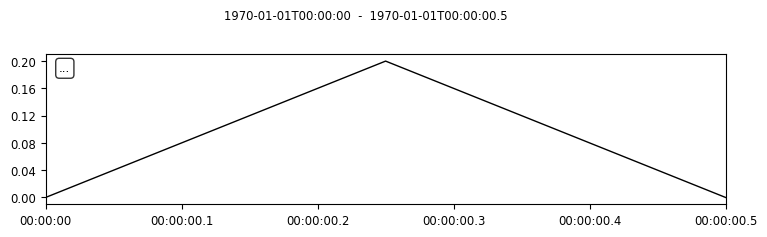

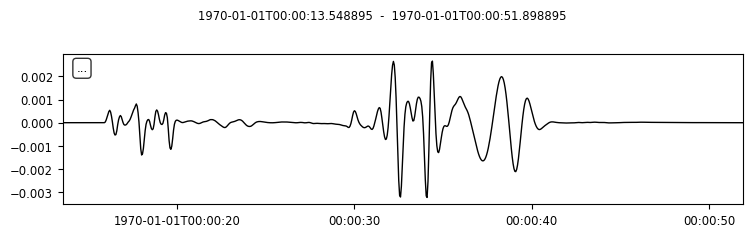

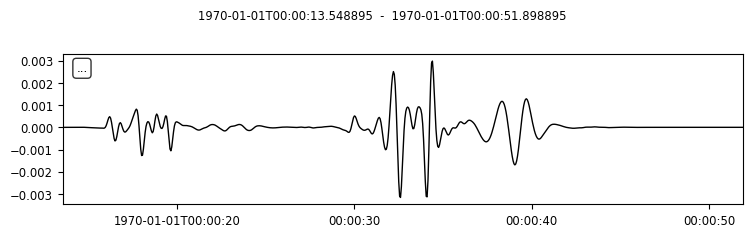

In [4]:
# Generate a source time function for the synthetic event
source_time_function = generate_source_time_function(
    dura=0.5,  # Duration of the source time function (seconds)
    rise=0.5,  # Rise time (seconds)
    delta=gfs_sta[0][0][0].stats.delta  # Time step from the Green's function
)

# Update the source mechanism (magnitude, strike, dip, rake)
config.source.update_source_mechanism(np.array([4.0, 0, 90, 0]))

# Calculate the synthetic seismogram for a specific Green's function and configuration
sync_result = calculate_sync(gfs_sta[3], config, 45, source_time_function)

idx = 100 - 1  # Select the 100th receiver (Python uses 0-based indexing)

# Plot the source time function
source_time_function.plot()

# Plot the synthetic waveform for the selected receiver
sync_result[idx][0].plot()

# Extract the waveform data for further processing
waveform = sync_result[idx][0].data
n = len(waveform)
trigle = np.tri(n, n)  # Lower triangular matrix (not used further here)

# Make a copy of the synthetic result for filtering
sync_result_to_filter = sync_result[idx].copy()

# Apply a bandpass filter to the synthetic waveform (0.5-4 Hz)
sync_result_to_filter.filter("bandpass", freqmin=0.5, freqmax=4, zerophase=True)

# Plot the filtered synthetic waveform
sync_result_to_filter[0].plot()

## Generate Dataset
This section generates a large dataset of synthetic waveforms for training machine learning models or for further analysis.

In [ ]:
dt = 0.05  # Time step for the synthetic data

import matplotlib.pyplot as plt
from obspy import UTCDateTime
import os
import time
plt.figure(figsize=(5,5))
import random

N = 10000  # Number of synthetic events to generate
n_sta = 32  # Number of stations per event
outdir = 'Train_waveform_Italy_8/'  # Output directory for the dataset
radius = 80  # Maximum station distance from the source (km)
shift_ratio = 0.1  # Maximum random shift as a fraction of radius

if not os.path.exists(outdir):
    os.mkdir(outdir)

mag = 3.0  # Initial magnitude (will be randomized)

earthquake_list = open(outdir + 'earthquakes.txt', 'w')  # File to record event metadata

starttime = time.time()  # Start timing

for k in range(1, N + 1):

    i_sta = random.randint(32, n_sta + 1)  # Random number of stations for this event

    mag = np.random.random() * 3 + 1  # Random magnitude between 1 and 4
    source_time_function_sta = generate_source_time_function(
        dura=0.5, rise=0.5, delta=gfs_sta[0][0][0].stats.delta
    )
    # Choose a different source time function for scattering models based on magnitude
    if mag > 3.5:
        source_time_function_sct = generate_source_time_function(dura=0.4, rise=0.5, delta=gfs_sta[0][0][0].stats.delta)
    elif mag > 2.5:
        source_time_function_sct = generate_source_time_function(dura=0.2, rise=0.5, delta=gfs_sta[0][0][0].stats.delta)
    else:
        source_time_function_sct = generate_source_time_function(dura=0.1, rise=0.5, delta=gfs_sta[0][0][0].stats.delta)

    if k % 10 == 0:
        check = time.time()
        print('getting waveforms for event: ' + str(k) + '  time usage: ' + str(check - starttime))
        starttime = check

    waveforms0 = np.random.randn(n_sta, 2, 768)  # Placeholder for standard waveforms (R, Z)
    waveformsF = np.random.randn(n_sta, 3, 768)  # Placeholder for filtered waveforms (R, T, Z)

    event_dir = outdir + str(k)
    if not os.path.exists(event_dir):
        os.mkdir(event_dir)
    station_list = open(event_dir + '/stations.txt', 'w')
    strike = np.round(np.random.random() * 360, 1)
    dip = np.round(np.random.random() * 90, 1)
    rake = np.round((np.random.random() - 0.5) * 360, 1)

    dep = np.random.random() * 20 + 1  # Random depth between 1 and 21 km

    source = sources[int(np.clip(round(dep) - 1, 0, 39))]
    source.update_source_mechanism(np.array([mag, strike, dip, rake]))
    config.source = source

    greenf_sta = gfs_sta[int(np.clip(round(dep) - 1, 0, 39))]
    greenf_sct = gfs_sct[np.random.randint(4)][int(np.clip(round(dep) - 1, 0, 39))]

    earthquake_list.write(
        '%5s' % str(k) + '  0  0' + '%7s' % str('%.2f' % dep) + '%6s' % str('%.2f' % mag) +
        '%8s' % str('%.1f' % strike) + '%8s' % str('%.1f' % dip) + '%8s' % str('%.1f' % rake) + '\n'
    )

    ang_start = 0  # Starting angle for station distribution

    r_shift = np.round(np.random.random() * shift_ratio * radius, 2)
    az_shift = np.round(np.random.random() * 2 * np.pi, 4)

    x_shift = r_shift * np.sin(az_shift)
    y_shift = r_shift * np.cos(az_shift)

    for i in range(1, n_sta + 1):
        if i <= i_sta:
            ang = np.random.random() * 2 * np.pi + ang_start
            r = np.floor(np.sqrt(np.random.random()) * radius + 1)
            X = r * np.sin(ang)
            Y = r * np.cos(ang)

            azi = ang * 360 / (2 * np.pi)

            X = X - x_shift
            Y = Y - y_shift

            azi = np.arctan2(X, Y) * 180 / np.pi % 360

            r = np.sqrt(X ** 2 + Y ** 2)

            sync_result_sta = calculate_sync(
                greenf_sta[min(max(int(round(r)) - 1, 0), 149)], config, azi, source_time_function_sta
            )
            sync_result_sct = calculate_sync(
                greenf_sct[min(max(int(round(r)) - 1, 0), 149)], config, azi, source_time_function_sct
            )

            stream_sta = sync_result_sta[0].copy()
            stream_sct = sync_result_sct[0].copy()

            p_time = 50 * dt
            s_time = stream_sta[0].meta['sac']['t2'] - stream_sta[0].meta['sac']['t1'] + p_time

            Z0 = stream_sta[0].data
            R0 = stream_sta[1].data

            station_list.write(
                '%2s' % str(i) + '%9s' % str(round(X, 3)) + '%10s' % str(round(Y, 3)) +
                '%9s' % str(round(p_time, 3)) + '%9s' % str(round(s_time, 3)) + '\n'
            )

            waveforms0[i - 1, 0, :] = R0
            waveforms0[i - 1, 1, :] = Z0

            stream_sct.filter("bandpass", freqmin=0.5, freqmax=4, corners=4)

            ZF = stream_sct[0].data
            RF = stream_sct[1].data
            TF = stream_sct[2].data
            waveformsF[i - 1, 0, :] = RF
            waveformsF[i - 1, 1, :] = TF
            waveformsF[i - 1, 2, :] = ZF

    np.save(event_dir + '/waveform0.npy', waveforms0)
    np.save(event_dir + '/waveformF.npy', waveformsF)

    station_list.close()

earthquake_list.close()

getting waveforms for event: 10  time usage: 2.953760862350464
getting waveforms for event: 20  time usage: 3.015228271484375
getting waveforms for event: 30  time usage: 3.2444586753845215
getting waveforms for event: 40  time usage: 2.981382131576538
getting waveforms for event: 50  time usage: 2.9334940910339355
getting waveforms for event: 60  time usage: 2.770089864730835
getting waveforms for event: 70  time usage: 2.991472005844116
getting waveforms for event: 80  time usage: 3.148818016052246
getting waveforms for event: 90  time usage: 2.673389196395874
getting waveforms for event: 100  time usage: 2.665188789367676
getting waveforms for event: 110  time usage: 2.6336472034454346
getting waveforms for event: 120  time usage: 3.151993751525879
getting waveforms for event: 130  time usage: 3.063429117202759
getting waveforms for event: 140  time usage: 2.9029979705810547
getting waveforms for event: 150  time usage: 2.903512954711914
getting waveforms for event: 160  time usage:

<Figure size 500x500 with 0 Axes>

In [23]:
np.random.randint(4)

3

## Amatrice
This section generates synthetic waveforms for the Amatrice earthquake sequence, using real event and station metadata.

### Loads a dictionary containing event metadata and polarities for the Amatrice sequence.

In [23]:
data_pol = np.load('Amatrice/lowpass_polarities.npy', allow_pickle=True).item()
eids = list(data_pol.keys())  # List of event IDs
len(data_pol)  # Number of events

120

### Generate synthetic waveforms for Amatrice events

In [24]:
dt = 0.02  # Time step for the synthetic data

import matplotlib.pyplot as plt
from obspy import UTCDateTime
import os
import time
plt.figure(figsize=(5,5))
import random

outdir = 'Amatrice_syn/'  # Output directory for synthetic waveforms

if not os.path.exists(outdir):
    os.mkdir(outdir)

mag = 3.0  # Magnitude (fixed for all events here)

source_time_function = generate_source_time_function(dura=0.1, rise=0.5, delta=gfs[0][0][0].stats.delta)

earthquake_list = open(outdir + 'earthquakes.txt', 'w')

n_sta = 32  # Number of stations per event

starttime = time.time()

for k in range(0, len(eids)):

    eid = eids[k]

    if (k+1) % 10 == 0:
        check = time.time()
        print('getting waveforms for event: ' + str(k+1) + '  time usage: ' + str(check - starttime))
        starttime = check

    waveforms = np.random.randn(n_sta, 3, 2048)  # Placeholder for synthetic waveforms (R, T, Z)
    waveforms_f = np.random.randn(n_sta, 3, 2048)  # Placeholder for filtered waveforms

    event_dir = outdir + str(eid)
    if not os.path.exists(event_dir):
        os.mkdir(event_dir)
    station_list = open(event_dir + '/stations.txt', 'w')
    focmec = data_pol[eid]['focalmech']  # Focal mechanism: [strike, dip, rake]
    stationxyz = data_pol[eid]['stationxyz']  # Station coordinates and depths
    strike = focmec[0]
    dip = focmec[1]
    rake = focmec[2]
    dep = float(stationxyz[0, -1])  # Source depth

    i_sta = len(stationxyz)  # Number of stations for this event

    source = sources[int(np.clip(round(dep)-1, 0, 39))]
    source.update_source_mechanism(np.array([mag, strike, dip, rake]))
    config.source = source
    greenf = gfs[int(np.clip(round(dep)-1, 0, 39))]

    earthquake_list.write('%10s' % str(eid) + '  0  0' + '%7s' % str('%.2f' % dep) + '%6s' % str(mag) + '%8s' % str(strike)
                           + '%8s' % str(dip) + '%8s' % str(rake) + '\n')

    for i in range(0, i_sta):

        if i >= n_sta:
            continue

        X = float(stationxyz[i, 1])
        Y = float(stationxyz[i, 2])

        azi = np.arctan2(X, Y) * 180 / np.pi % 360  # Azimuth from source to station
        r = np.sqrt(X**2 + Y**2)  # Distance from source to station

        sync_result = calculate_sync(greenf[min(max(int(round(r))-1, 0), 150)], config, azi, source_time_function)

        stream = sync_result[0].copy()

        p_time = 50 * dt
        s_time = stream[0].meta['sac']['t2'] - stream[0].meta['sac']['t1'] + p_time

        stnm = stationxyz[i, 0]

        station_list.write('%5s' % str(stnm) + '%9s' % str(round(X,3)) + '%10s' % str(round(Y,3)) + '%9s' % str(round(p_time,3))+ '%9s' % str(round(s_time,3)) + '\n')

        waveforms[i, 0, :] = R
        waveforms[i, 1, :] = T
        waveforms[i, 2, :] = Z

        stream.filter("bandpass", freqmin=0.2, freqmax=2, corners=4,)

        R = stream[1].data
        Z = stream[0].data
        T = stream[2].data
        waveforms_f[i, 0, :] = R
        waveforms_f[i, 1, :] = T
        waveforms_f[i, 2, :] = Z

    np.save(event_dir+'/waveform.npy', waveforms)
    np.save(event_dir+'/waveform_f.npy', waveforms_f)

    station_list.close()

earthquake_list.close()

getting waveforms for event: 10  time usage: 1.6782078742980957
getting waveforms for event: 20  time usage: 1.333693265914917
getting waveforms for event: 30  time usage: 1.8277668952941895
getting waveforms for event: 40  time usage: 1.3888270854949951
getting waveforms for event: 50  time usage: 1.4165959358215332
getting waveforms for event: 60  time usage: 1.6026320457458496
getting waveforms for event: 70  time usage: 1.9111249446868896
getting waveforms for event: 80  time usage: 1.462636947631836
getting waveforms for event: 90  time usage: 1.6201281547546387
getting waveforms for event: 100  time usage: 1.9361109733581543
getting waveforms for event: 110  time usage: 1.852975845336914
getting waveforms for event: 120  time usage: 1.7260160446166992


<Figure size 500x500 with 0 Axes>

### Compute polarity and amplitude ratios for synthetics

In [40]:
import numpy as np
from glob import glob
import os
import random

n = 2048
n_sta = 32
dt = 0.02

Dirs = ['Amatrice_syn/', ]
Dir = Dirs[0]

mcs = np.loadtxt(Dirs[0]+'earthquakes.txt')

data_pol_syn = {}

eids = mcs[:, 0].astype(int).astype(str)

for k in range(len(eids)):

    eid = eids[k]
    focal = mcs[k, 5:]
    dep = mcs[k, 3]

    data_pol[eid] = {}
    data_pol[eid]['polarities'] = np.empty((0, 10))
    data_pol[eid]['stationxyz'] = np.empty((0, 4))
    data_pol[eid]['focalmech']  = focal

    station = np.loadtxt(Dir+str(eid)+'/stations.txt', dtype=str)

    p_times = station[:, 3].astype(float)
    s_times = station[:, 4].astype(float)
    stations = list(station[:,0].astype(str))
    waveforms = np.load(Dir+str(eid)+'/waveform_f.npy')
    waveforms0 = np.load(Dir+str(eid)+'/waveform.npy')
    ratios = np.ones((n_sta, 10))*-100

    mag = np.random.uniform(-5.0, -4.0)

    for j in range(len(stations)):

        stnm = stations[j]
        x = station[j, 1]
        y = station[j, 2]
        z = str(dep)

        #r = np.sqrt(x**2 + y**2 + z**2)

        xyzs = np.array([stnm, x, y, z]).reshape(1,-1)

        data_pol[eid]['stationxyz'] = np.append(data_pol[eid]['stationxyz'], xyzs, axis=0)

        R0 = waveforms[j,0,:]
        Z0 = waveforms[j,1,:] 
        T0 = waveforms[j,2,:] 

        P0 = waveforms0[j,2,:]

        p_time = p_times[j]
        s_time = s_times[j]
        p_end = min(p_time + 1, s_time)  # End of P window (cannot go past S arrival)

        # Extract windows for P and S phases on each component
        Pr0 = R0[int((p_time-0.2)/dt): int(p_end/dt)]
        Pz0 = Z0[int((p_time-0.2)/dt): int(p_end/dt)]
        Pt0 = T0[int((p_time-0.2)/dt): int(p_end/dt)]
        Sr0 = R0[int((s_time-0.2)/dt): int((s_time+1)/dt)]
        Sz0 = Z0[int((s_time-0.2)/dt): int((s_time+1)/dt)]
        St0 = T0[int((s_time-0.2)/dt): int((s_time+1)/dt)]

        r_ratio = 1.2

        # Add noise to the synthetic data
        R = R0 + np.random.randn(n) * 10**mag * r_ratio ** np.random.randn()
        Z = Z0 + np.random.randn(n) * 10**mag * r_ratio ** np.random.randn()
        T = T0 + np.random.randn(n) * 10**mag * r_ratio ** np.random.randn()

        # Extract windows from noisy data
        Pr = R[int((p_time-0.2)/dt): int(p_end/dt)]
        Pz = Z[int((p_time-0.2)/dt): int(p_end/dt)]
        Pt = T[int((p_time-0.2)/dt): int(p_end/dt)]
        Sr = R[int((s_time-0.2)/dt): int((s_time+1)/dt)]
        Sz = Z[int((s_time-0.2)/dt): int((s_time+1)/dt)]
        St = T[int((s_time-0.2)/dt): int((s_time+1)/dt)]

        # Extract noise windows (first 20 samples)
        Nr = R[:20]
        Nz = Z[:20]
        Nt = T[:20]

        r_ratio = 1.5

        # Compute amplitude measures for each window
        PrA = np.max(np.abs(Pr)) * r_ratio ** np.random.randn()
        PzA = np.max(np.abs(Pz)) * r_ratio ** np.random.randn()
        PtA = np.max(np.abs(Pt)) * r_ratio ** np.random.randn()
        SrA = np.max(np.abs(Sr)) * r_ratio ** np.random.randn()
        StA = np.max(np.abs(St)) * r_ratio ** np.random.randn()
        SzA = np.max(np.abs(Sz)) * r_ratio ** np.random.randn()

        # Combine S and P amplitudes for more robust measures
        SrA = np.sqrt(SrA**2 + 0.5*PrA**2)
        SzA = np.sqrt(SzA**2 + 0.5*PzA**2)
        StA = np.sqrt(StA**2 + 0.5*PtA**2)

        PPA = np.max(np.sqrt(Pr**2 + Pz**2))  # P amplitude (vector sum)
        SSA = np.max([SrA, StA, SzA])         # S amplitude (max of components)

        NrA = np.sqrt(np.var(Nr)) * r_ratio ** np.random.randn()
        NzA = np.sqrt(np.var(Nz)) * r_ratio ** np.random.randn()
        NtA = np.sqrt(np.var(Nt)) * r_ratio ** np.random.randn()

        # Compute polarity: sign of the largest amplitude in the P window
        pol = P0[45:55]
        pol = np.sign(pol[np.argmax(np.abs(pol))])

        # Compute log-amplitude ratios for use in ML or QC
        ratios = np.array([
            1, SrA/PrA, SrA/PzA, SzA/PrA, SzA/PzA, StA/PrA, StA/PzA,
            SSA/PPA, PzA/NzA, StA/NtA
        ])
        ratios = np.log(ratios)
        ratios[0] = pol  # First entry is polarity

        # Store in the data structure
        data_pol[eid]['polarities'] = np.append(
            data_pol[eid]['polarities'],
            ratios.reshape(1, -1), axis=0
        )

# Save the synthetic polarities and ratios to disk
np.save('Amatrice/polarities_syn_noise.npy', data_pol)


In [325]:
station # display station metadata for last processed event

array([['T1214', '-4.023', '-0.073', '1.0', '2.317'],
       ['T1204', '4.824', '-9.349', '1.0', '2.989'],
       ['T1201', '-0.578', '-11.428', '1.0', '2.989'],
       ['T1213', '-10.815', '-3.921', '1.0', '3.107'],
       ['NRCA', '-11.737', '8.156', '1.0', '3.349'],
       ['T1218', '-11.694', '-10.007', '1.0', '3.473'],
       ['MMO1', '5.631', '15.458', '1.0', '3.599'],
       ['T1243', '15.606', '-7.055', '1.0', '3.726'],
       ['T1241', '14.168', '10.694', '1.0', '3.853'],
       ['T1212', '-17.45', '-0.941', '1.0', '3.726'],
       ['MC2', '-5.5', '16.947', '1.0', '3.853'],
       ['T1216', '-19.511', '14.528', '1.0', '4.634'],
       ['LNSS', '-17.853', '-17.459', '1.0', '4.766'],
       ['T1246', '19.303', '-19.621', '1.0', '5.162'],
       ['CAMP', '12.417', '-24.913', '1.0', '5.162'],
       ['RM33', '-3.563', '-27.9', '1.0', '5.162']], dtype='<U7')

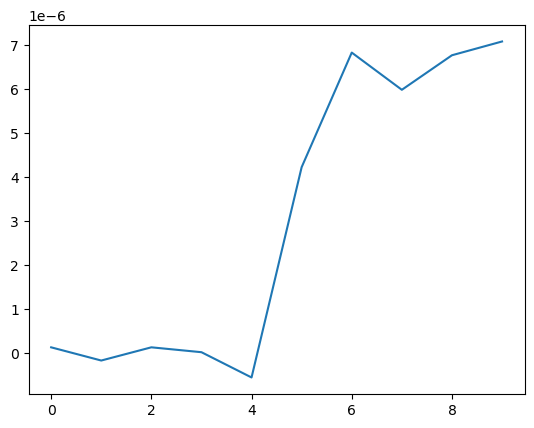

In [176]:
plt.plot(P0[45:55]) # plot P-wave window used for polarity picking for last station/event

In [118]:
pol # display computed polairty value for last station/event

-1.0

### Compare polarity datasets
- Loads observed, synthetic, and noisy synthetic polarity datasets.
- Collects all polarity values into arrays for comparison or statistical analysis.

In [100]:
data_pol = np.load('Amatrice/polarities.npy', allow_pickle=True).item()
data_pol_syn_noise = np.load('Amatrice/polarities_syn_noise.npy', allow_pickle=True).item()
data_pol_syn = np.load('Amatrice/polarities_syn.npy', allow_pickle=True).item()

eids = list(data_pol.keys())

SoP1 = []
SoP2 = []
SoP3 = []

for eid in eids:
    data1 = data_pol[eid]
    data2 = data_pol_syn[eid]
    data3 = data_pol_syn_noise[eid]
    stations1 = data1['stationxyz'][:, 0]
    stations2 = data2['stationxyz'][:, 0]
    stations3 = data3['stationxyz'][:, 0]

    pol1 = data1['polarities'][:, 0]
    pol2 = data2['polarities'][:, 0]
    pol3 = data3['polarities'][:, 0]

    for j in range(len(stations2)):
        SoP1.append(pol1[j])
        SoP2.append(pol2[j])
        SoP3.append(pol3[j])

SoP1 = np.array(SoP1)
SoP2 = np.array(SoP2)
SoP3 = np.array(SoP3)

### Generate and filter a synthetic example
- Generates a synthetic waveform for a specific source mechanism and azimuth, then filters and plots the result.
- Useful for visual inspection and quality control.

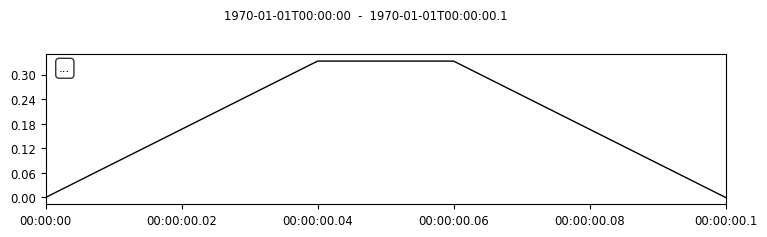

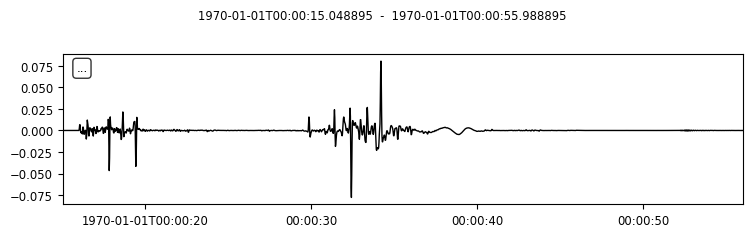

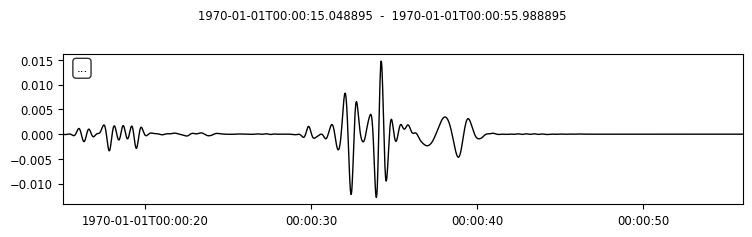

In [21]:
source_time_function=generate_source_time_function(dura=0.1, rise=0.5, delta=gfs[0][0][0].stats.delta)
config.source.update_source_mechanism(np.array([4.0, 45, 90, 0]))
sync_result = calculate_sync(gfs[3], config, 90, source_time_function)
idx = 100-1

source_time_function.plot();

sync_result[idx][0].plot();

waveform = sync_result[idx][0].data
n = len(waveform)
trigle = np.tri(n, n)

sync_result_to_filter=sync_result[idx].copy()
#sync_result_to_filter.detrend("linear")
#sync_result_to_filter.taper(max_percentage=0.05, type='hann')
sync_result_to_filter.filter("bandpass", freqmin=0.2, freqmax=2,zerophase=True)

sync_result_to_filter[0].plot();
